# Trace Analysis with Causal Process Models
*Timotheus Kampik and Mathias Weske*

This notebook demonstrates how we can use *causal* process models for drawing inferences about the quality of traces and event logs.

## Causal Process Models
First, let us explain what a causal process model is.
Consider the process depicted by the figure below.


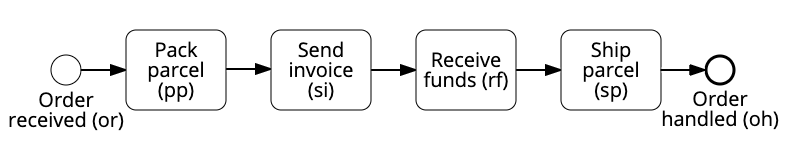

Clearly, the process is *supposed to* run as follows.

1. The process starts when an order is received ($or$).

2. Then, the parcel is packed with the items that have been ordered ($pp$).

3. Subsequently, the invoice for the order is sent separately ($si$).

4. When the funds have been received and processed ($rf$),

5. The parcel is shipped ($sp$),

6. Which ends the processed, as the order is considered handled ($or$).

In practice, the process may, however, run differently, even if it *should run exactly as specified*.
Hence, we call the model above a *normative* process model.
In contrast to a normative process model, a *causal* process model models exactly the relations that a process instance must necessarily comply with in any case.
In our example:

1. none of the activities can be executed before the order has been received;

2. The parcel cannot be shipped before it has been packed (we assume shipping an unpacked parcel is unrealistic and will not happen);

3. Funds cannot be received before the invoice as been sent.

These assumptions leave us with the causal process model below, which relaxes some of the constraints that our initial normative process model imposes.


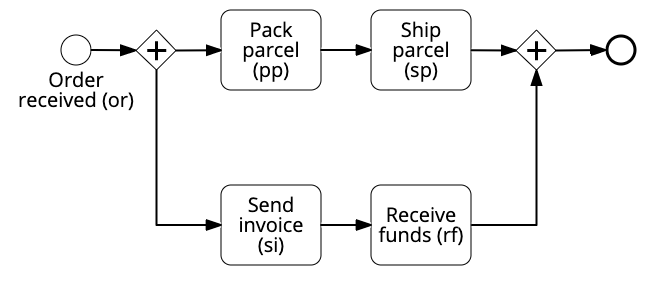

## Causal Compliance
Given a causal process model, we can then check if a trace or event log that contains process execution data is causally compliant.
In contrast to normative compliance violations, causal compliance problems point to data quality issues: the causal constraints can only be violated if the trace is incorrect, for example because the clocks of different systems that produce the time stamps are not in sync or because the assignment of events to cases is incorrect.
We can check the causal compliance of a trace with a causal process model by translating the process model into a set of Linear Temporal Logic (LTL) constraints.
Given the diagram above, all constraints are 'precedes' constraints.
In LTL, we can express '$a$ precedes $b$' as $G(b \implies \neg b R a)$, intuitively as 'globally, $b$ does not occur before $a$ has occurred'. Note that we do not positively predict the future, i.e., we do not claim that if $a$ precedes $b$, then $b$ must necessarily follow after $a$: for us, $a$ is not inevitably cause $b$ to occur, but is merely a *causal precondition*.
Let us now model the constraints using an LTL solver (the [metric-temporal-logic](https://github.com/mvcisback/py-metric-temporal-logic) Python package).

In [201]:
%%capture
!pip3 install metric-temporal-logic

In [202]:
import math
import mtl
# specify set of activity variables
act_vars = ['or', 'pp', 'sp', 'si', 'rf']
# specify set of precedes constraints (binary relation on {or, pp, sp, si, rf})
precedes_constraints = [('or', 'pp'), ('or', 'sp'), ('or', 'si'), ('or', 'rf'), ('pp', 'sp'), ('si', 'rf')]

# generate LTL statements
def neg(x): # negation helper
  return f'(~{x})'

def release(x, y): # release helper, as the release operator is not implemented in the LTL solver
  return f'G(~(~{x} U ~{y}))'

def pc_constraints_to_ltl(constraints): # our custom 'precedes' operator/function
  return [f'G({b} -> {release(neg(b), a)})' for (a, b) in constraints]
    
precedes_constraints_ltl = pc_constraints_to_ltl(precedes_constraints)

# compliant trace
t1 = ['or', 'pp', 'sp', 'si', 'rf']
# non-compliant trace
t2 = ['or', 'pp', 'sp', 'rf']

# trace to LTL path
def trace_to_path(trace, act_vars):
    path = {}
    for act in act_vars:
        path[act] = []
        index = math.inf
        for idx, aid in enumerate(trace):
            if aid == act:
                index = idx
            if index > idx:
                path[act].append((idx, False))
            else:
                path[act].append((idx, True)) 
    return path

# check if trace complies
def check_compliance(trace, constraints, act_vars):
    path = trace_to_path(trace, act_vars)
    violations = 0
    for constraint in constraints:
        if not mtl.parse(constraint)(path, time=0, quantitative=False):
            violations += 1
    return violations

print(f'Compliance violations trace {t1} (t1): ', check_compliance(t1, precedes_constraints_ltl, act_vars))
print(f'Compliance violations trace {t2} (t2): ', check_compliance(t2, precedes_constraints_ltl, act_vars))

Compliance violations trace ['or', 'pp', 'sp', 'si', 'rf'] (t1):  0
Compliance violations trace ['or', 'pp', 'sp', 'rf'] (t2):  1


Given our causal constraints and a trace, we can determine the trace's *degree of causal compliance* with respect to the constraints as the number of constraints that are *not violated* divided by the total number of constraints.
The degree of causal compliance of an event log is the average degree of compliance of the event log's cases.

In [203]:
# Based on the number of constraints that are violated, we compute the degree of causal compliance
def determine_trace_compliance(trace, constraints, act_vars):
    if len(constraints) == 0:
        return 1
    return (len(constraints) - check_compliance(trace, constraints, act_vars)) / len(constraints)

# The degree of causal compliance of an event log is the average degree of compliance of the event log's cases
def determine_log_compliance(log, constraints, act_vars):
    degrees = [determine_trace_compliance(trace, constraints, act_vars) for trace in log]
    return sum(degrees) / len(degrees)

print('Degree of compliance t1: ', determine_trace_compliance(t1, precedes_constraints_ltl, act_vars))
print('Degree of compliance t2: ', determine_trace_compliance(t2, precedes_constraints_ltl, act_vars))
print('Degree of compliance log [t1, t2]: ', determine_log_compliance([t1, t2], precedes_constraints_ltl, act_vars))

Degree of compliance t1:  1.0
Degree of compliance t2:  0.8333333333333334
Degree of compliance log [t1, t2]:  0.9166666666666667


## Disjunctions and Conjunctions
Let us model the constraints of the common conjunction and disjunctions, and provide compliance checks for some example traces. Note that in case of the (inclusive) OR, we have a 'precedes-if-occurs' constraint, e.g., in the bottom-left model, $a$ must precedes $b$ only if $a$ occurs. In addition, we have mutual negations ($NAND$), $OR$ and $XOR$ disjunctions between activities, which we also need to model as constraints.

* **Precedes-if-occurs.** A *precedes-if-occurs* relationship between two activities $a$ and $b$ can be expressed as $G(F(a) \implies (b \implies \neg b R a))$ -- intuitively, *globally, if $a$ occurs then $b$ does not occur until $a$ has occurred*.

* **Mutual negation.** A *mutual negation* ($NAND$) relationship between two activities $a$ and $b$ can be expressed as $G((a \implies \neg a) \land (b \implies \neg a))$.

* **OR.** The OR relationship between some activities $S' = \{a_0, ...., a_n\}$, given the set of activities $S^{''}$ that precede all activities in $S'$ in a *precedes-if-occurs* relationship can be expressed as $\forall c \in S^{''}$, $G(c \implies F(\bigvee_{a \in S'} a))$.

* **Exclusive OR.** Let us observe that an *exclusive OR* between some activities $S' = \{a_0, ...., a_n\}$ can be split into a set of mutual negations between these activities and an OR constraint that is modeled under consideration of the activities $S^{''}$ that precede all activities in $S'$ in a *precedes-if-occurs* relationship (see above).
  
In the figure below, we see some simple example processes that rely in different ways on logical conjunctions and (exclusive and inclusive) disjunctions.
The code that follows implements the LTL-based abstractions that are required to model the aforementioned relationships and disjunctions and demonstrates their application on the example processes.

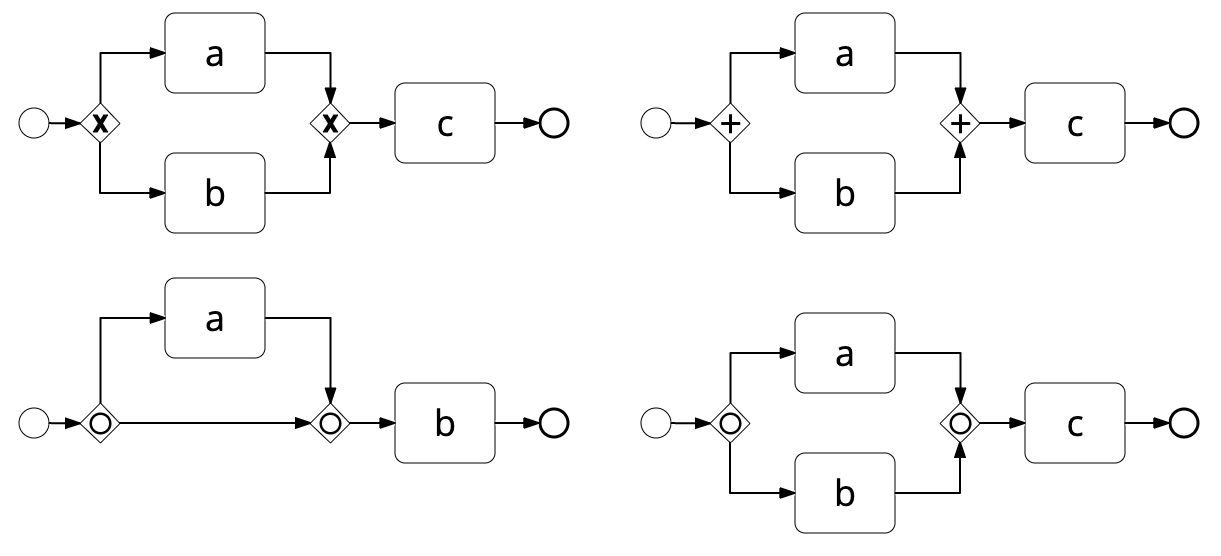

In [204]:
# 'precedes-if-occurs' constraints generator
def pio_constraints_to_ltl(constraints):
    return [f'G(F({a}) -> ({b} -> {release(neg(b), a)}))' for (a, b) in constraints]

# 'mutual negation'/NAND constraints generator
def neg_constraints_to_ltl(constraints):
    return [f'G(({a} -> ~{b}) & ({b} -> ~{a}))' for (a, b) in constraints]

# XOR operator/function
def xor_constraints_to_ltl(constraints):
    ltl_statements = []
    for (variables, successors) in constraints:
        ltl_statement_list_1 = []
        for a in variables:
            for b in variables:
                if not a == b:
                    ltl_statement_list_1.append(neg_constraints_to_ltl([(a, b)])[0])
        joined_vars = ' | '.join(variables)
        ltl_statement_list_2 = [f'G({successor} -> F({joined_vars}))' for successor in successors]          
        ltl_statements.append('(' + ' & '.join(ltl_statement_list_1) + ' & ' + ' & '.join(ltl_statement_list_2) + ')')
    return ltl_statements

# OR operator/function
def or_constraints_to_ltl(constraints):
    ltl_statements = []
    for (variables, successors) in constraints:
        joined_vars = ' | '.join(variables)
        ltl_statement_list_2 = [f'G({successor} -> F({joined_vars}))' for successor in successors]          
        ltl_statements.append('(' + ' & '.join(ltl_statement_list_2) + ')')
    return ltl_statements

# sets of action variables
act_vars_1 = ['a', 'b', 'c']
act_vars_2 = ['a', 'b']

# top-left
pio_constraints_tl = [('a', 'c'), ('b', 'c')]
pio_constraints_tl_ltl = pio_constraints_to_ltl(constraints_tl)
xor_constraints = [(['a', 'b'], ['c'])]
xor_constraints_t1_ltl = xor_constraints_to_ltl(xor_constraints)
all_constraints_tl_ltl = pio_constraints_tl_ltl + xor_constraints_t1_ltl

t_tl_1 = ['c', 'a'] # Non-compliant: c must not precede a
t_tl_2 = ['a', 'b', 'c'] # Non-compliant: a and b are mutually exclusive
t_tl_3 = ['a'] # We do not predict the future: consequently, this trace is compliant!
t_tl_4 = ['a', 'b'] # Non-compliant: a and b are mutually exclusive
t_tl_5 = ['c'] # Non-compliant: c must be preceded by either a or b
t_tl_6 = ['a', 'c'] # Obviously compliant

tc_tl = [t_tl_1, t_tl_2, t_tl_3, t_tl_4, t_tl_5, t_tl_6]

print(f'Compliance violations trace {t_1_1} (t_1_1): ', check_compliance(t_1_1, all_constraints_tl_ltl, act_vars_1))
print(f'Compliance violations trace {t_tl_2} (t_tl_2): ', check_compliance(t_tl_2, all_constraints_tl_ltl, act_vars_1))
print(f'Compliance violations trace {t_tl_3} (t_tl_3): ', check_compliance(t_tl_3, all_constraints_tl_ltl, act_vars_1))
print(f'Compliance violations trace {t_tl_4} (t_tl_4): ', check_compliance(t_tl_4, all_constraints_tl_ltl, act_vars_1))
print(f'Compliance violations trace {t_tl_5} (t_tl_5): ', check_compliance(t_tl_5, all_constraints_tl_ltl, act_vars_1))
print(f'Compliance violations trace {t_tl_6} (t_tl_6): ', check_compliance(t_tl_6, all_constraints_tl_ltl, act_vars_1))
print('Degree of compliance log tc_tl: ', determine_log_compliance(tc_tl, all_constraints_tl_ltl, act_vars_1))

# top-right
pc_constraints_tr = [('a', 'c'), ('b', 'c')]
pc_constraints_tr_ltl = pc_constraints_to_ltl(pc_constraints_tr)
t_tr_1 = ['a'] # We do not predict the future: consequently, this trace is compliant!
t_tr_2 = ['a', 'c'] # Non-compliant: c must be preceded by a AND b
t_tr_3 = ['c', 'b'] # Non-compliant: c must be preceded by a AND b, b must not precede c
t_tr_4 = ['a', 'b'] # We do not predict the future: consequently, this trace is compliant!
t_tr_5 = ['a', 'b', 'c'] # Obviously compliant

tc_tr = [t_tr_1, t_tr_2, t_tr_3, t_tr_4, t_tr_5]

print(f'Compliance violations trace {t_tr_1} (t_tr_1): ', check_compliance(t_tr_1, pc_constraints_tr_ltl, act_vars_1))
print(f'Compliance violations trace {t_tr_2} (t_tr_2): ', check_compliance(t_tr_2, pc_constraints_tr_ltl, act_vars_1))
print(f'Compliance violations trace {t_tr_3} (t_tr_3): ', check_compliance(t_tr_3, pc_constraints_tr_ltl, act_vars_1))
print(f'Compliance violations trace {t_tr_4} (t_tr_4): ', check_compliance(t_tr_4, pc_constraints_tr_ltl, act_vars_1))
print(f'Compliance violations trace {t_tr_5} (t_tr_5): ', check_compliance(t_tr_5, pc_constraints_tr_ltl, act_vars_1))
print('Degree of compliance log tc_tl: ', determine_log_compliance(tc_tr, pc_constraints_tr_ltl, act_vars_1))

# bottom-left
constraints_bl = [('a', 'b')]
constraints_bl_ltl = pio_constraints_to_ltl(constraints_bl)
t_bl_1 = ['b', 'a'] # Non-compliant: b must not precede a
t_bl_2 = ['a', 'b'] # Obviously compliant
t_bl_3 = ['a'] # We do not predict the future: consequently, this trace is compliant!
tc_bl = [t_bl_1, t_bl_2, t_bl_3]

print(f'Compliance violations trace {t_bl_1} (t_bl_1): ', check_compliance(t_bl_1, constraints_bl_ltl, act_vars_2))
print(f'Compliance violations trace {t_bl_2} (t_bl_2): ', check_compliance(t_bl_2, constraints_bl_ltl, act_vars_2))
print(f'Compliance violations trace {t_bl_3} (t_bl_3): ', check_compliance(t_bl_3, constraints_bl_ltl, act_vars_2))
print('Degree of compliance log tc_tl: ', determine_log_compliance(tc_bl, constraints_bl_ltl, act_vars_2))

# bottom-right
pio_constraints_br = [('a', 'c'), ('b', 'c')]
or_constraints_br = [(['a', 'b'], ['c'])]
pio_constraints_br_ltl = pio_constraints_to_ltl(pio_constraints_br)
or_constraints_br_ltl = or_constraints_to_ltl(or_constraints_br)
all_constraints_br_ltl = pio_constraints_br_ltl + or_constraints_br_ltl

t_br_1 = ['c', 'a'] # Non-compliant: c must not precede a
t_br_2 = ['a', 'b', 'c'] # Obviously compliant
t_br_3 = ['a'] # We do not predict the future: consequently, this trace is compliant!
t_br_4 = ['a', 'b'] # We do not predict the future: consequently, this trace is compliant!
t_br_5 = ['c'] # Non-compliant: c must be preceded by a or b
t_br_6 = ['a', 'c'] # Obviously compliant

tc_br = [t_br_1, t_br_2, t_br_3, t_br_4, t_br_5, t_br_6]

print(f'Compliance violations trace {t_br_1} (t_br_1): ', check_compliance(t_br_1, all_constraints_br_ltl, act_vars_1))
print(f'Compliance violations trace {t_br_2} (t_br_2): ', check_compliance(t_br_2, all_constraints_br_ltl, act_vars_1))
print(f'Compliance violations trace {t_br_3} (t_br_3): ', check_compliance(t_br_3, all_constraints_br_ltl, act_vars_1))
print(f'Compliance violations trace {t_br_4} (t_br_4): ', check_compliance(t_br_4, all_constraints_br_ltl, act_vars_1))
print(f'Compliance violations trace {t_br_5} (t_br_5): ', check_compliance(t_br_5, all_constraints_br_ltl, act_vars_1))
print(f'Compliance violations trace {t_br_6} (t_br_6): ', check_compliance(t_br_6, all_constraints_br_ltl, act_vars_1))
print('Degree of compliance log tc_tl: ', determine_log_compliance(tc_br, all_constraints_br_ltl, act_vars_1))






Compliance violations trace ['c', 'a'] (t_1_1):  1
Compliance violations trace ['a', 'b', 'c'] (t_tl_2):  1
Compliance violations trace ['a'] (t_tl_3):  0
Compliance violations trace ['a', 'b'] (t_tl_4):  1
Compliance violations trace ['c'] (t_tl_5):  1
Compliance violations trace ['a', 'c'] (t_tl_6):  0
Degree of compliance log tc_tl:  0.6666666666666666
Compliance violations trace ['a'] (t_tr_1):  0
Compliance violations trace ['a', 'c'] (t_tr_2):  1
Compliance violations trace ['c', 'b'] (t_tr_3):  2
Compliance violations trace ['a', 'b'] (t_tr_4):  0
Compliance violations trace ['a', 'b', 'c'] (t_tr_5):  0
Degree of compliance log tc_tl:  0.7
Compliance violations trace ['b', 'a'] (t_bl_1):  1
Compliance violations trace ['a', 'b'] (t_bl_2):  0
Compliance violations trace ['a'] (t_bl_3):  0
Degree of compliance log tc_tl:  0.6666666666666666
Compliance violations trace ['c', 'a'] (t_br_1):  1
Compliance violations trace ['a', 'b', 'c'] (t_br_2):  0
Compliance violations trace ['a']

## Managing Loops
Note that we assume our causal process model is acyclic, *i.e.*, that it does not contain loops.
However, loops that do not intersect other loops can be handled via simple abstractions.
Consider the process model below.

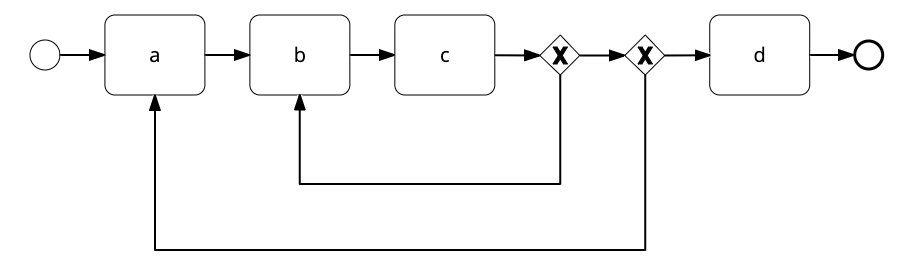

It contains two loops.
Because the loops are not intersecting, we can reduce them by considering the loop $b$ - $c$ - $b$ a sub-process and each $b$ - $c$ iteration of the loop a sub-process instance.
Then, we can use the label $(bc)^*$ to denote an activity that models an arbitrary (but non-zero) number of occurrences of the sub-process $b$ - $c$.
Subsequently, we can reduce $a$ - $(bc)^*$ - $a$ to $(a(bc)^*)^*$, which in turn models an arbitrary, non-zero number of occurrences of the sub-process $a$ - $(bc^*)$.
The figure below shows the process models in which the loops $b$ - $c$ - $b$ and $a$ - $(bc)^*$ - $a$ have been reduced.

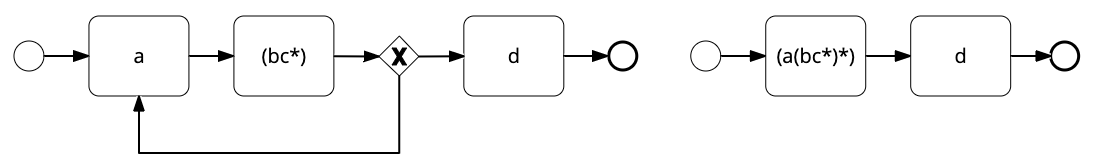

Intersecting loops like the one shown in the figure below cannot be reduced using this approach.
However, it can be assumed that the modeling of nested loops is an edge case that is rarely of practical relevance.

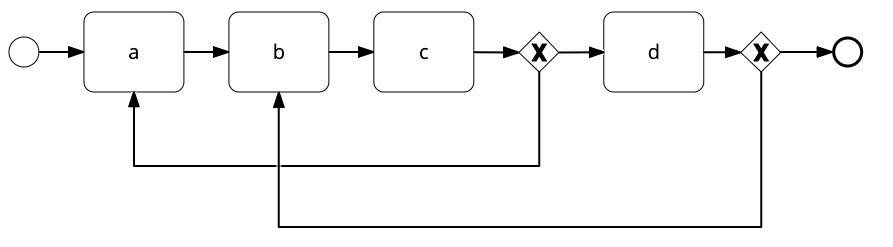

## Application Potential

Our causal process modeling and compliance approach introduces a fundamentally new view on the constraints that a process model represents: while a 'traditional' process model (with normative relationships between activities and events) specifies how a process supposedly or ideally runs, a causal process model specifies how a process must necessarily run, because of constraints that can be safely assumed to not be violated.
Let us argue that this distinction is not merely of philosophical interest, but of practical relevance in industry settings where process modeling is often used to build an initial understanding of a process that is about to be mined.
A normative compliance violation allows us to infer that the process does not run as expected; in contrast, we can infer from a causal compliance violation that the data we have gathered about the process is faulty.
This means that we can draw inferences about data quality faults in traces -- and hence in event logs, as formalized in the previous section.
Analyzing and addressing event log faults is a highly relevant challenge in industry-scale process mining, and from a compliance checking view, the distinction between normative and causal process is crucial for addressing this challenge.

When confronted with causal compliance errors, a process mining engineer or technical consultant has the following action alternatives.

* Obviously, one can annotate traces and event logs with meta-data about their degree of casual compliance and then present this information to the process analysts that take care of the business-oriented interpretation of the data. A process analyst may decide to apply process mining algorithms to different event log subsets that contain all traces, only high quality traces, and only low quality traces, respectively, to then compare the results. If, for instance, a specific normative (non-causal) compliance violation only occurs in traces that contain specific causal compliance violations, further investigation is necessary before one can conclude that there is indeed a compliance problem and not a data quality problem.

* One can try to solve the data quality issues by investigating potential errors that may have been made when scoping the process, *e.g.*, when identifying or generating the case identifiers of the process' instances, or when generating the event log. An alternative root cause for data quality issues can be system clocks that are out of sync and based on which event time stamps are generated: such issues, which can typically only be fixed *before* a process instance is executed, need to be investigated as well.

* One can *repair* the traces that have errors, for example by inserting missing events representing activities that must have occurred as causal preconditions of activities that have indeed been logged in a given trace.